In [1]:
import sys
sys.path.insert(0, '..')

# DiffLUT Tutorial: Training on MNIST Dataset

This notebook demonstrates how to:
1. Use the DiffLUT registry system
2. Encode images using Thermometer encoding
3. Create LUT nodes and layers
4. Stack layers to build a complete model
5. Train on MNIST and visualize results

## What is DiffLUT?
DiffLUT (Differentiable Look-Up Tables) is a neural network framework that uses lookup tables instead of traditional matrix multiplications. This makes them highly efficient for deployment on FPGAs and other hardware.

## 1. Setup and Imports

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

# Import DiffLUT components
from difflut import REGISTRY
from difflut.utils.modules import GroupSum
from difflut.utils.regularizers import l2_weights, l1_weights, COMMON_REGULARIZERS

print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Could not save font_manager cache Lock error: Matplotlib failed to acquire the following lock file:
    /home/sbuehrer/.cache/matplotlib/fontlist-v390.json.matplotlib-lock
This maybe due to another process holding this lock file.  If you are sure no
other Matplotlib process is running, remove this file and try again.


PyTorch version: 2.7.1+cu126
CUDA available: False
Using device: cpu


/usr/itetnas04/data-scratch-01/sbuehrer/data/difflut/examples/../difflut/nodes/cuda/__init__.py:18: UserWarning: CUDA extension efd_cuda not available: No module named 'efd_cuda'. Using CPU fallback.
  warnings.warn(f"CUDA extension efd_cuda not available: {e}. Using CPU fallback.")
/itet-stor/sbuehrer/net_scratch/conda_envs/myenv/lib/python3.10/site-packages/torch/cuda/__init__.py:174: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at /pytorch/c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


## 2. Explore Available Components in Registry

The DiffLUT registry provides a centralized way to access different types of:
- **Nodes**: The basic LUT units (e.g., DWN, LinearLUT, PolyLUT)
- **Layers**: How nodes are connected (e.g., Random, Cyclic, Learnable)
- **Encoders**: How to convert continuous values to binary (e.g., Thermometer)

In [3]:
# Display all available components
print("\n=== Available DiffLUT Components ===")
print("\nNodes (LUT types):")
for node in REGISTRY.list_nodes():
    print(f"  - {node}")

print("\nLayers (connection patterns):")
for layer in REGISTRY.list_layers():
    print(f"  - {layer}")

print("\nEncoders (binarization methods):")
for encoder in REGISTRY.list_encoders():
    print(f"  - {encoder}")


=== Available DiffLUT Components ===

Nodes (LUT types):
  - dwn
  - linear_lut
  - probabilistic
  - polylut
  - neurallut

Layers (connection patterns):
  - random
  - learnable
  - cyclic

Encoders (binarization methods):
  - thermometer
  - gaussian_thermometer
  - distributive_thermometer


## 3. Load and Visualize MNIST Data

In [4]:
# Load MNIST dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: torch.flatten(x))  # Flatten 28x28 to 784
])

train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)

# Use a subset for faster training in this tutorial
subset_size = 10000
test_subset_size = 1000

train_indices = torch.randperm(len(train_dataset))[:subset_size]
test_indices = torch.randperm(len(test_dataset))[:test_subset_size]

train_subset = torch.utils.data.Subset(train_dataset, train_indices)
test_subset = torch.utils.data.Subset(test_dataset, test_indices)

print(f"Training samples: {len(train_subset)}")
print(f"Test samples: {len(test_subset)}")

Training samples: 10000
Test samples: 1000


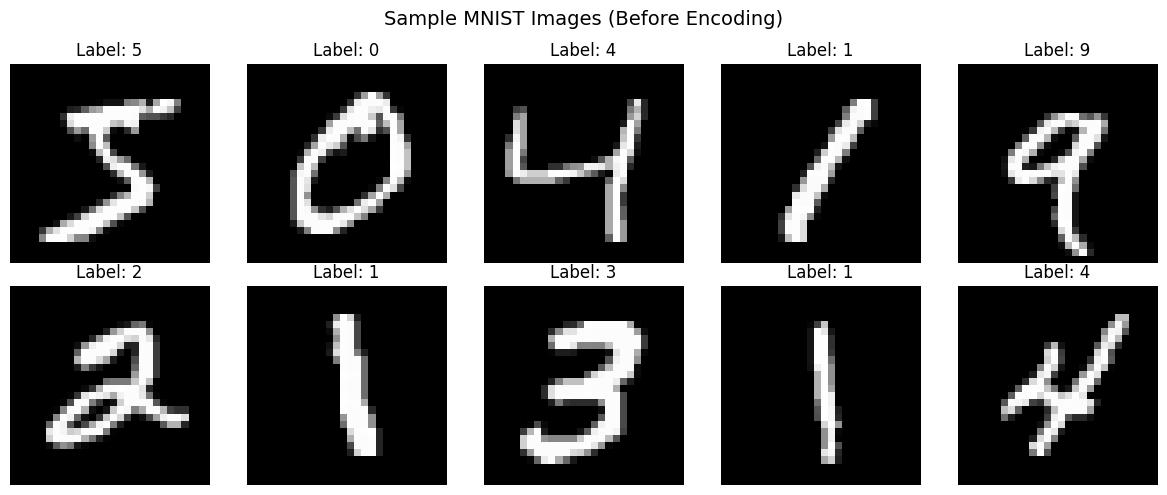

In [5]:
# Visualize some sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    img, label = train_dataset[i]
    img_2d = img.reshape(28, 28)
    ax.imshow(img_2d, cmap='gray')
    ax.set_title(f'Label: {label}')
    ax.axis('off')
plt.suptitle('Sample MNIST Images (Before Encoding)', fontsize=14)
plt.tight_layout()
plt.show()

## 4. Encode Images with Thermometer Encoding

DiffLUT works with binary inputs. We use **Thermometer Encoding** to convert grayscale pixel values (0-1) into multiple binary bits.

For example, with 3 bits:
- Low value (0.2) → `[0, 0, 0]`
- Medium value (0.5) → `[1, 1, 0]`
- High value (0.9) → `[1, 1, 1]`

In [6]:
# Get encoder from registry
ThermometerEncoder = REGISTRY.get_encoder("thermometer")

# Configuration
num_thermometer_bits = 3

# Create encoder
encoder = ThermometerEncoder(num_bits=num_thermometer_bits, feature_wise=True)

# Load all training data to fit the encoder
temp_loader = DataLoader(train_subset, batch_size=len(train_subset), shuffle=False)
x_train, y_train = next(iter(temp_loader))

# Fit encoder to training data (computes thresholds)
encoder.fit(x_train)

print(f"Original input size: {x_train.shape[1]} pixels")
print(f"Thermometer bits per pixel: {num_thermometer_bits}")
print(f"Encoded size: {x_train.shape[1] * num_thermometer_bits} bits")

Original input size: 784 pixels
Thermometer bits per pixel: 3
Encoded size: 2352 bits


In [7]:
# Encode training and test data
x_train_encoded = encoder.encode(x_train)
print(f"Encoded training data shape: {x_train_encoded.shape}")

# Load and encode test data
temp_loader = DataLoader(test_subset, batch_size=len(test_subset), shuffle=False)
x_test, y_test = next(iter(temp_loader))
x_test_encoded = encoder.encode(x_test)

print(f"Encoded test data shape: {x_test_encoded.shape}")

Encoded training data shape: torch.Size([10000, 2352])
Encoded test data shape: torch.Size([1000, 2352])


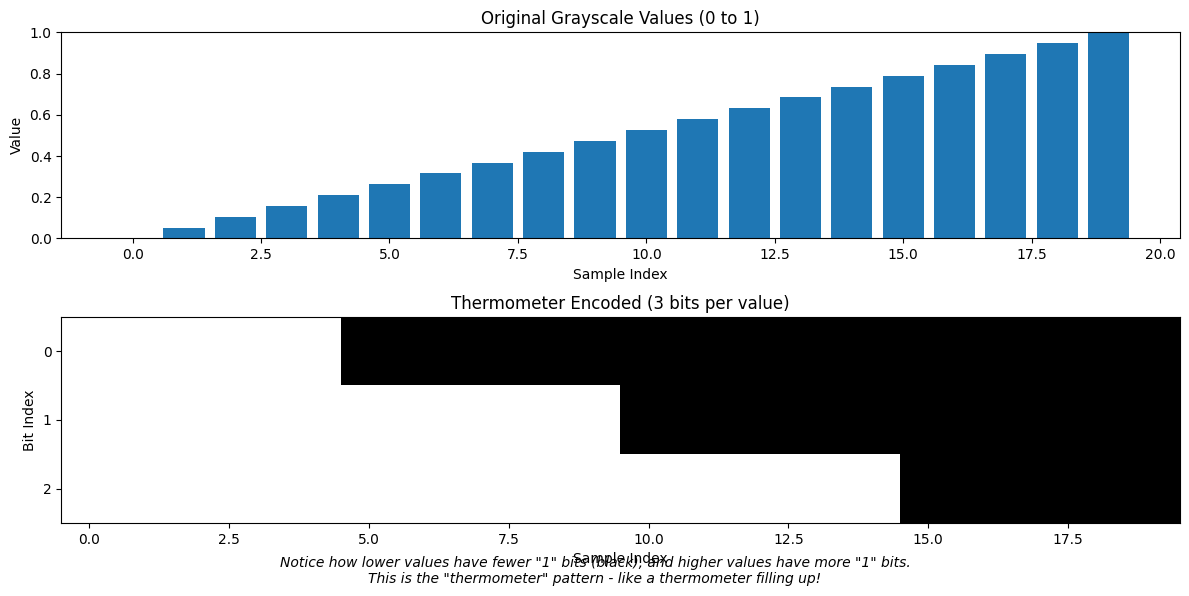


Thresholds used: [0.25 0.5  0.75]
For a value to produce a '1' in bit i, it must be > threshold[i]


In [8]:
# Visualize encoding effect on a single pixel
# Create a simple encoder for demonstration (not feature-wise, single feature)
demo_encoder = ThermometerEncoder(num_bits=num_thermometer_bits, feature_wise=False)

# Create sample values and fit the demo encoder
sample_values = torch.linspace(0, 1, 20)
demo_encoder.fit(sample_values)

# Encode the sample values
sample_encoded = demo_encoder.encode(sample_values)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Original values
ax1.bar(range(len(sample_values)), sample_values.numpy())
ax1.set_title('Original Grayscale Values (0 to 1)')
ax1.set_ylabel('Value')
ax1.set_ylim([0, 1])
ax1.set_xlabel('Sample Index')

# Encoded values
ax2.imshow(sample_encoded.T.numpy(), cmap='binary', aspect='auto')
ax2.set_title(f'Thermometer Encoded ({num_thermometer_bits} bits per value)')
ax2.set_xlabel('Sample Index')
ax2.set_ylabel('Bit Index')
ax2.set_yticks(range(num_thermometer_bits))

# Add explanation text
fig.text(0.5, 0.02, 
         'Notice how lower values have fewer "1" bits (black), and higher values have more "1" bits.\n'
         'This is the "thermometer" pattern - like a thermometer filling up!',
         ha='center', fontsize=10, style='italic')

plt.tight_layout()
plt.subplots_adjust(bottom=0.12)
plt.show()

# Print thresholds for clarity
print(f"\nThresholds used: {demo_encoder.thresholds.numpy()}")
print(f"For a value to produce a '1' in bit i, it must be > threshold[i]")

### Understanding Thermometer Encoding

The thermometer encoder converts each continuous value into multiple binary bits:

**How it works:**
1. Fit the encoder to training data to compute thresholds
2. For each value, compare it against each threshold
3. If value > threshold, output `1`, else output `0`

**Example with 3 bits:**
- Thresholds at: 0.25, 0.50, 0.75
- Value = 0.3 → `[1, 0, 0]` (above 0.25 only)
- Value = 0.6 → `[1, 1, 0]` (above 0.25 and 0.50)
- Value = 0.9 → `[1, 1, 1]` (above all thresholds)

**Why it's called "thermometer":**
Like a mercury thermometer, the encoding "fills up" from bottom to top as the value increases!

**Feature-wise vs Global:**
- **Feature-wise** (what we're using): Each pixel gets its own thresholds based on its distribution
- **Global**: All pixels share the same thresholds

Original image shape: torch.Size([784])
Encoded output shape: torch.Size([2352])
✓ Each of the 784 pixels gets encoded into 3 binary values
✓ Total encoding size: 784 × 3 = 2352 bits (flattened)

Found 147 non-zero pixels (where the digit is)


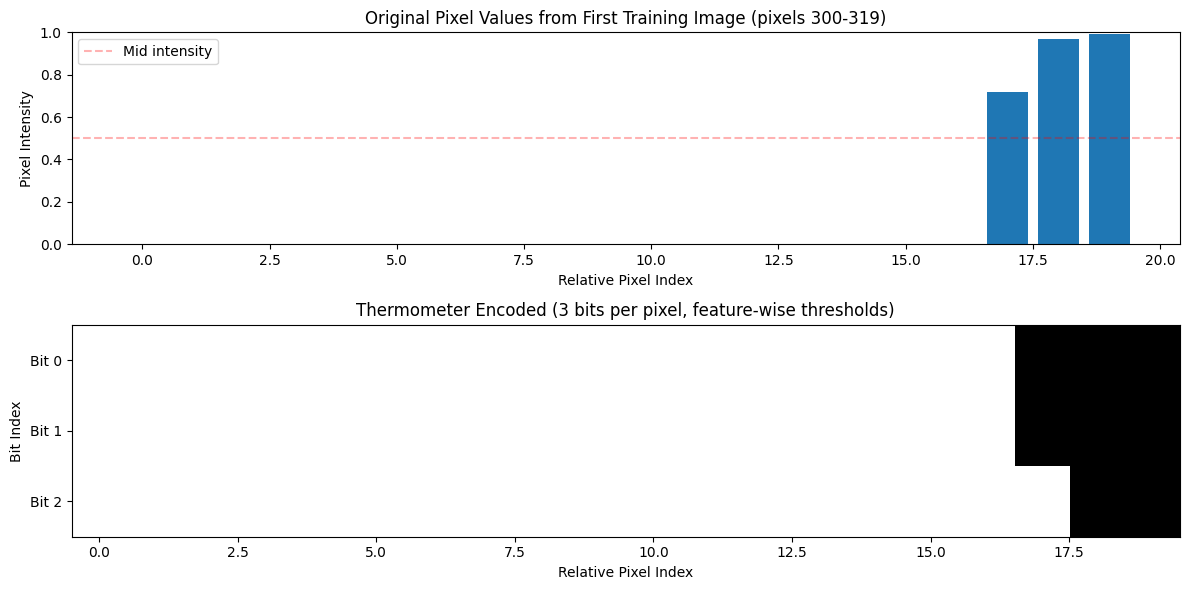


Note: The actual output is flattened into a 1D vector of 2352 bits
      Showing pixels from the center region where the digit is more likely to appear
      Black cells = 1 (above threshold), White cells = 0 (below threshold)


In [9]:
# Let's also visualize how a real image gets encoded
# The encoder will flatten the output: (784 pixels, 3 bits) -> 2352 bits total
sample_img_full = x_train[0]  # Full image (784 pixels)

# Encode the full image using the actual trained encoder
encoded_full = encoder.encode(sample_img_full.unsqueeze(0)).squeeze(0)

print(f"Original image shape: {sample_img_full.shape}")
print(f"Encoded output shape: {encoded_full.shape}")
print(f"✓ Each of the 784 pixels gets encoded into {num_thermometer_bits} binary values")
print(f"✓ Total encoding size: {784} × {num_thermometer_bits} = {encoded_full.shape[0]} bits (flattened)")

# Reshape to visualize structure: (784 pixels, 3 bits per pixel)
encoded_reshaped = encoded_full.reshape(784, num_thermometer_bits)

# Find pixels with non-zero values (where the digit is)
non_zero_pixels = torch.where(sample_img_full > 0.1)[0]
print(f"\nFound {len(non_zero_pixels)} non-zero pixels (where the digit is)")

# Select pixels from the middle region where the digit typically appears
# MNIST images are 28×28, so center region is around rows 10-18, cols 10-18
# In flattened form: pixels from index ~300 to ~500
start_idx = 300
num_pixels_to_show = 20
pixel_indices = range(start_idx, start_idx + num_pixels_to_show)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6))

# Original pixel values from center region
pixel_values = sample_img_full[pixel_indices]
ax1.bar(range(num_pixels_to_show), pixel_values.numpy())
ax1.set_title(f'Original Pixel Values from First Training Image (pixels {start_idx}-{start_idx+num_pixels_to_show-1})')
ax1.set_ylabel('Pixel Intensity')
ax1.set_ylim([0, 1])
ax1.set_xlabel('Relative Pixel Index')
ax1.axhline(y=0.5, color='r', linestyle='--', alpha=0.3, label='Mid intensity')
ax1.legend()

# Encoded values (corresponding pixels, reshaped for visualization)
encoded_subset = encoded_reshaped[pixel_indices]
ax2.imshow(encoded_subset.T.numpy(), cmap='binary', aspect='auto')
ax2.set_title(f'Thermometer Encoded (3 bits per pixel, feature-wise thresholds)')
ax2.set_xlabel('Relative Pixel Index')
ax2.set_ylabel('Bit Index')
ax2.set_yticks([0, 1, 2])
ax2.set_yticklabels(['Bit 0', 'Bit 1', 'Bit 2'])

plt.tight_layout()
plt.show()

print(f"\nNote: The actual output is flattened into a 1D vector of {encoded_full.shape[0]} bits")
print(f"      Showing pixels from the center region where the digit is more likely to appear")
print(f"      Black cells = 1 (above threshold), White cells = 0 (below threshold)")

## 6. Build DiffLUT Model from Components

Now we'll build a model by:
1. Getting node and layer types from the registry
2. Creating individual layers with LUT nodes
3. Optionally adding custom regularization to nodes
4. Stacking them together into a complete network

## 5. Understanding Regularization in DiffLUT

DiffLUT supports flexible custom regularization for each node. By default, **no regularization** is applied unless you explicitly specify it.

### Regularization Options:

1. **No Regularization (default)**: `node_regularizers=None`
2. **L2 Weight Decay**: `{"l2": [l2_weights, 0.001]}`
3. **L1 Sparsity**: `{"l1": [l1_weights, 0.0001]}`
4. **Combined**: Multiple regularizers in one dict
5. **Presets**: Use `COMMON_REGULARIZERS` for pre-configured settings

### Format:
```python
node_regularizers = {
    "reg_name": [regularization_function, weight],
    "another_reg": [another_function, weight],
    ...
}
```

The regularization is automatically applied to all nodes in all layers!

In [10]:
class DiffLUTModel(nn.Module):
    """
    DiffLUT Model built using registry components.
    """
    def __init__(self, input_size, hidden_sizes, output_size=10, n=6,
                 node_type='dwn', layer_type='random', node_regularizers=None):
        """
        Args:
            input_size: Size of input features (after encoding)
            hidden_sizes: List of hidden layer sizes [e.g., [1000, 1000]]
            output_size: Number of output classes (10 for MNIST)
            n: Number of inputs per LUT node (typically 4-8)
            node_type: Type of LUT node (e.g., 'dwn', 'linear_lut', 'neurallut')
            layer_type: Type of layer connection (e.g., 'random', 'cyclic', 'learnable')
            node_regularizers: Dict of regularization functions to pass to nodes
                              Format: {"name": [reg_fn, weight], ...}
        """
        super().__init__()
        
        # Get node and layer classes from registry
        print(f"\nBuilding model with:")
        print(f"  Node type: {node_type}")
        print(f"  Layer type: {layer_type}")
        print(f"  LUT inputs (n): {n}")
        if node_regularizers:
            print(f"  Regularizers: {list(node_regularizers.keys())}")
        
        self.node_class = REGISTRY.get_node(node_type)
        self.layer_class = REGISTRY.get_layer(layer_type)
        self.n = n
        
        # Build layers
        layers = []
        prev_size = input_size
        
        for i, hidden_size in enumerate(hidden_sizes):
            # Configure node parameters based on type
            node_kwargs = {}
            if node_type == 'dwn':
                # DWN-specific parameters for gradient computation
                node_kwargs = {
                    'alpha': 0.5 * 0.75 ** (n - 1), 
                    'beta': 0.25 / 0.75,
                    'output_dim': 1
                }
            
            # Add regularizers if specified
            if node_regularizers:
                node_kwargs['regularizers'] = node_regularizers
            
            # Create layer using registry components
            layer = self.layer_class(
                input_size=prev_size,
                output_size=hidden_size,
                node_type=self.node_class,
                n=n,
                node_kwargs=node_kwargs
            )
            layers.append(layer)
            
            print(f"  Layer {i+1}: {prev_size} → {hidden_size} (nodes: {hidden_size})")
            prev_size = hidden_size
        
        # Stack all layers
        self.layers = nn.ModuleList(layers)
        
        # Output layer: group nodes and sum for classification
        if prev_size % output_size != 0:
            raise ValueError(f"Last hidden size {prev_size} must be divisible by output size {output_size}")
        
        self.output_layer = GroupSum(k=output_size, tau=1)
        print(f"  Output layer: {prev_size} → {output_size} (via GroupSum)")
    
    def forward(self, x):
        """Forward pass through all layers."""
        # Ensure inputs are in [0, 1] range
        x = torch.clamp(x, 0, 1)
        
        # Pass through each LUT layer
        for layer in self.layers:
            x = layer(x)
        
        # Group and sum for final output
        x = self.output_layer(x)
        return x
    
    def regularization(self):
        """Compute regularization loss across all layers."""
        reg = 0.0
        for layer in self.layers:
            if hasattr(layer, 'regularization'):
                layer_reg = layer.regularization()
                # Only add if it has gradients or is non-zero
                if isinstance(layer_reg, torch.Tensor):
                    reg = reg + layer_reg
                else:
                    reg = reg + layer_reg
        return reg

In [11]:
# Model configuration
input_size = x_train_encoded.shape[1]  # Size after encoding
hidden_sizes = [1000, 1000]  # Two hidden layers
n_inputs = 6  # Number of inputs per LUT
num_classes = 10

# Optional: Add regularization to nodes
# Uncomment one of these to add regularization:

# Option 1: No regularization (default)
node_regularizers = None

# Option 2: L2 regularization
# node_regularizers = {"l2": [l2_weights, 0.001]}

# Option 3: Combined L1 and L2
# node_regularizers = {
#     "l2": [l2_weights, 0.001],
#     "l1": [l1_weights, 0.0001]
# }

# Option 4: Use preset
# node_regularizers = {"l2_medium": COMMON_REGULARIZERS["l2_medium"]}

# Create model
model = DiffLUTModel(
    input_size=input_size,
    hidden_sizes=hidden_sizes,
    output_size=num_classes,
    n=n_inputs,
    node_type='linear_lut',
    layer_type='random',
    node_regularizers=node_regularizers
).to(device)

print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

# Test regularization
reg_loss = model.regularization()
print(f"Regularization loss: {reg_loss.item():.6f}")


Building model with:
  Node type: linear_lut
  Layer type: random
  LUT inputs (n): 6
  Layer 1: 2352 → 1000 (nodes: 1000)
  Layer 2: 1000 → 1000 (nodes: 1000)
  Output layer: 1000 → 10 (via GroupSum)

Total parameters: 12,000
Regularization loss: 0.000000


## 7. Prepare Data Loaders

In [12]:
# Create datasets with encoded data
train_encoded_dataset = TensorDataset(x_train_encoded, y_train)
test_encoded_dataset = TensorDataset(x_test_encoded, y_test)

# Create data loaders
batch_size = 128
train_loader = DataLoader(train_encoded_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_encoded_dataset, batch_size=1000, shuffle=False)

print(f"Training batches: {len(train_loader)}")
print(f"Test batches: {len(test_loader)}")

Training batches: 79
Test batches: 1


## 8. Train the Model

In [13]:
# Training configuration
epochs = 10
learning_rate = 0.01
weight_decay = 1e-5

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# For tracking metrics
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

print("Starting training...\n")

Starting training...



In [14]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch."""
    model.train()
    total_loss = 0
    total_reg = 0
    correct = 0
    total = 0
    
    for batch_x, batch_y in tqdm(train_loader, desc='Training', leave=False):
        batch_x, batch_y = batch_x.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        
        # Add regularization
        reg_loss = model.regularization()
        
        # Handle regularization: only add if it's non-zero and is a tensor
        if isinstance(reg_loss, torch.Tensor):
            # It's a tensor - check if it has meaningful value
            if reg_loss.item() != 0:
                total_loss_with_reg = loss + reg_loss
            else:
                total_loss_with_reg = loss
            total_reg += reg_loss.item()
        else:
            # It's a Python float (0.0) - no regularization
            total_loss_with_reg = loss
            total_reg += reg_loss
        
        total_loss_with_reg.backward()
        optimizer.step()
        
        total_loss += loss.item()
            
        _, predicted = outputs.max(1)
        total += batch_y.size(0)
        correct += predicted.eq(batch_y).sum().item()
    
    avg_loss = total_loss / len(train_loader)
    avg_reg = total_reg / len(train_loader)
    accuracy = 100. * correct / total
    return avg_loss, avg_reg, accuracy

def evaluate(model, test_loader, criterion, device):
    """Evaluate the model."""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            outputs = model(batch_x)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += batch_y.size(0)
            correct += predicted.eq(batch_y).sum().item()
    
    avg_loss = total_loss / len(test_loader)
    accuracy = 100. * correct / total
    return avg_loss, accuracy

In [15]:
# Training loop
for epoch in range(epochs):
    # Train
    train_loss, train_reg, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    
    # Evaluate
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch {epoch+1}/{epochs}:")
    print(f"  Train Loss: {train_loss:.4f}, Reg: {train_reg:.6f}, Train Acc: {train_acc:.2f}%")
    print(f"  Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%")
    print()

print("Training complete!")

Training:   0%|          | 0/79 [00:00<?, ?it/s]

Epoch 1/10:
  Train Loss: 2.0911, Reg: 0.000000, Train Acc: 32.65%
  Test Loss: 2.3403, Test Acc: 65.40%



Epoch 2/10:
  Train Loss: 1.1392, Reg: 0.000000, Train Acc: 74.50%
  Test Loss: 1.5352, Test Acc: 77.50%



Epoch 3/10:
  Train Loss: 0.6544, Reg: 0.000000, Train Acc: 84.51%
  Test Loss: 1.4213, Test Acc: 79.90%



Epoch 4/10:
  Train Loss: 0.5172, Reg: 0.000000, Train Acc: 86.41%
  Test Loss: 1.0295, Test Acc: 84.30%



Epoch 5/10:
  Train Loss: 0.4475, Reg: 0.000000, Train Acc: 87.58%
  Test Loss: 1.0266, Test Acc: 85.60%



Epoch 6/10:
  Train Loss: 0.4066, Reg: 0.000000, Train Acc: 88.80%
  Test Loss: 0.9577, Test Acc: 86.20%



Epoch 7/10:
  Train Loss: 0.3820, Reg: 0.000000, Train Acc: 89.10%
  Test Loss: 0.9441, Test Acc: 86.90%



Epoch 8/10:
  Train Loss: 0.3602, Reg: 0.000000, Train Acc: 89.77%
  Test Loss: 0.8801, Test Acc: 87.10%



Epoch 9/10:
  Train Loss: 0.3424, Reg: 0.000000, Train Acc: 90.18%
  Test Loss: 0.8733, Test Acc: 87.80%



Epoch 10/10:
  Train Loss: 0.3351, Reg: 0.000000, Train Acc: 90.47%
  Test Loss: 0.8513, Test Acc: 87.60%

Training complete!


In [16]:
# Debug: Check if model parameters require gradients
print("Checking model parameters:")
param_count = 0
for name, param in model.named_parameters():
    param_count += 1
    if param_count <= 3:  # Show first 3 parameters
        print(f"  {name}: requires_grad={param.requires_grad}, shape={param.shape}")
print(f"Total parameters: {param_count}")

# Test forward pass
print("\nTesting forward pass with a small batch:")
test_batch = x_train_encoded[:2].to(device)
print(f"Input shape: {test_batch.shape}, requires_grad: {test_batch.requires_grad}")

model.train()
test_output = model(test_batch)
print(f"Output shape: {test_output.shape}, requires_grad: {test_output.requires_grad}")

# Test loss computation
test_labels = y_train[:2].to(device)
test_loss = criterion(test_output, test_labels)
print(f"Loss: {test_loss.item():.4f}, requires_grad: {test_loss.requires_grad}")

Checking model parameters:
  layers.0.nodes.0.weights: requires_grad=True, shape=torch.Size([6, 1])
  layers.0.nodes.1.weights: requires_grad=True, shape=torch.Size([6, 1])
  layers.0.nodes.2.weights: requires_grad=True, shape=torch.Size([6, 1])
Total parameters: 2000

Testing forward pass with a small batch:
Input shape: torch.Size([2, 2352]), requires_grad: False
Output shape: torch.Size([2, 10]), requires_grad: True
Loss: 1.8763, requires_grad: True


## 9. Visualize Training Results

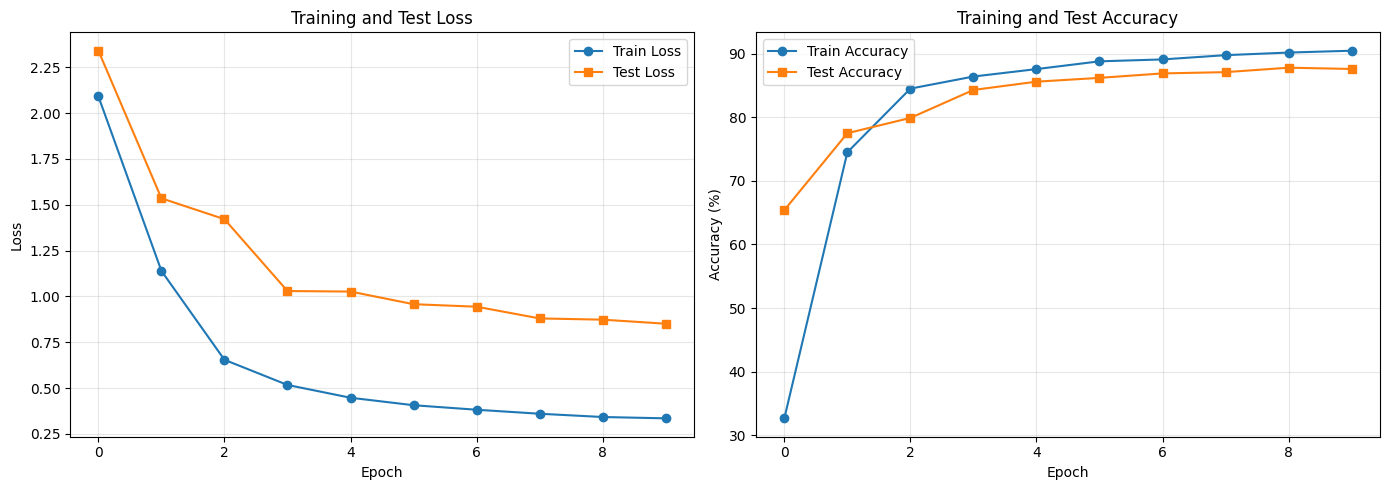


Final Test Accuracy: 87.60%


In [17]:
# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
ax1.plot(train_losses, label='Train Loss', marker='o')
ax1.plot(test_losses, label='Test Loss', marker='s')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Test Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Accuracy curves
ax2.plot(train_accuracies, label='Train Accuracy', marker='o')
ax2.plot(test_accuracies, label='Test Accuracy', marker='s')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy (%)')
ax2.set_title('Training and Test Accuracy')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFinal Test Accuracy: {test_accuracies[-1]:.2f}%")

## 10. Visualize Predictions on Test Images

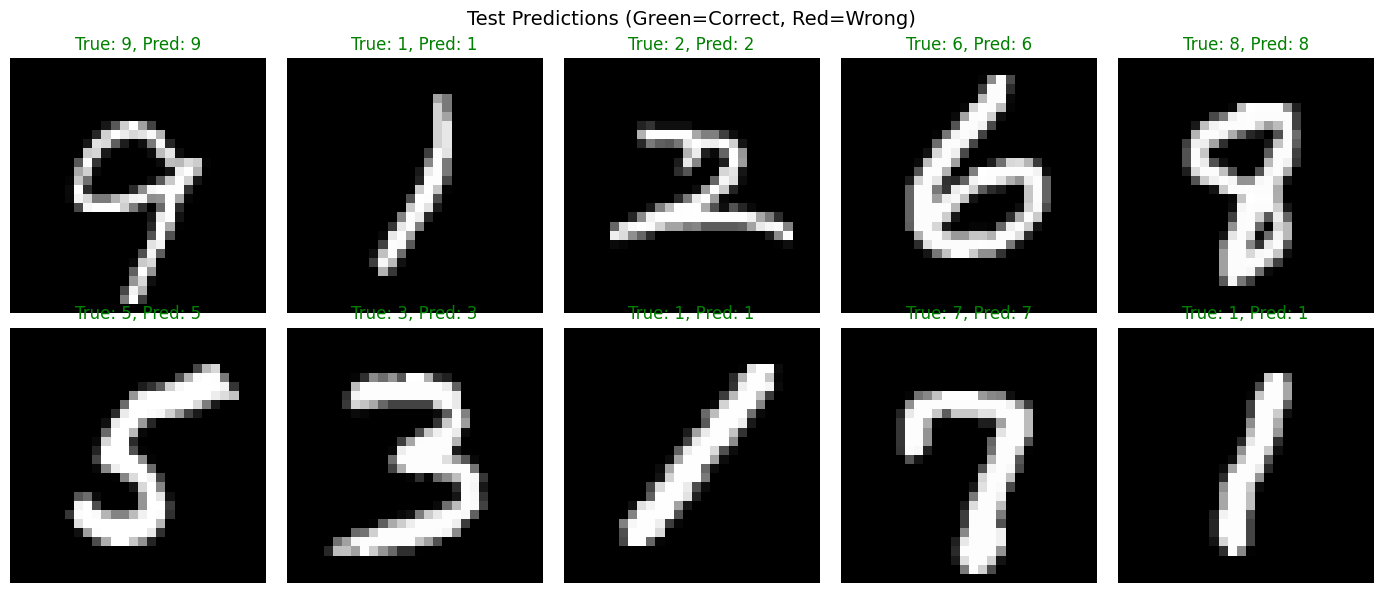

In [18]:
# Get some test predictions
model.eval()
num_samples = 10

with torch.no_grad():
    sample_x = x_test_encoded[:num_samples].to(device)
    sample_y = y_test[:num_samples]
    outputs = model(sample_x)
    _, predictions = outputs.max(1)
    predictions = predictions.cpu()

# Visualize
fig, axes = plt.subplots(2, 5, figsize=(14, 6))
for i, ax in enumerate(axes.flat):
    # Get original image (not encoded)
    img = x_test[i].reshape(28, 28)
    true_label = sample_y[i].item()
    pred_label = predictions[i].item()
    
    ax.imshow(img, cmap='gray')
    color = 'green' if true_label == pred_label else 'red'
    ax.set_title(f'True: {true_label}, Pred: {pred_label}', color=color)
    ax.axis('off')

plt.suptitle('Test Predictions (Green=Correct, Red=Wrong)', fontsize=14)
plt.tight_layout()
plt.show()

## 11. Confusion Matrix

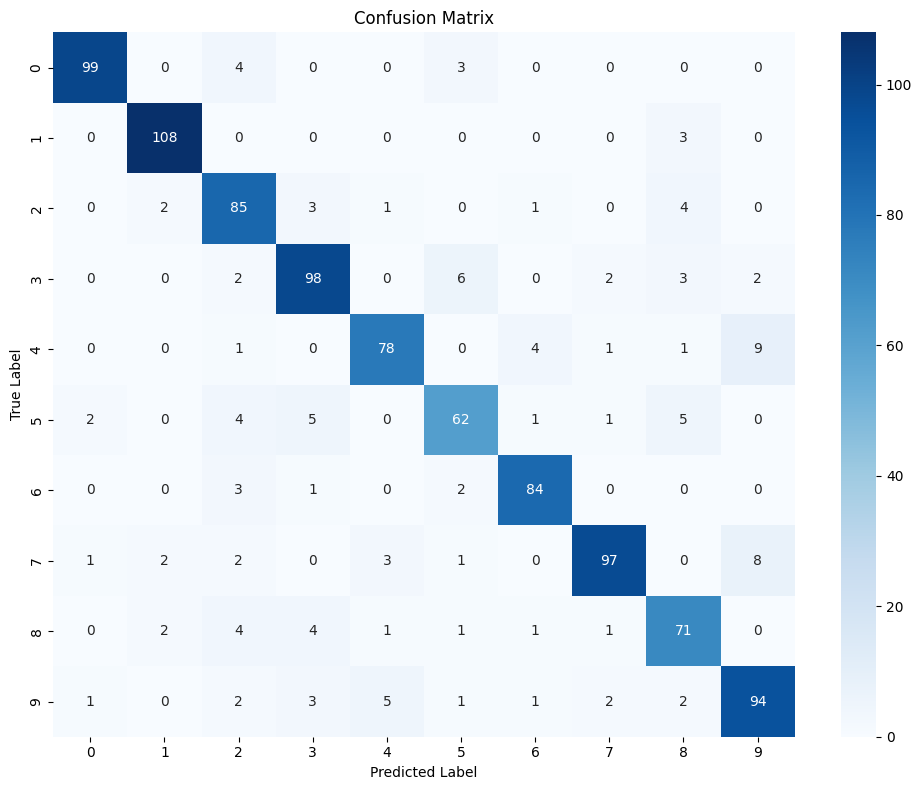

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Get all predictions
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_x, batch_y in test_loader:
        batch_x = batch_x.to(device)
        outputs = model(batch_x)
        _, preds = outputs.max(1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(batch_y.numpy())

# Compute confusion matrix
cm = confusion_matrix(all_labels, all_preds)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=range(10), yticklabels=range(10))
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.tight_layout()
plt.show()

## 12. Experiment with Different Components

The beauty of the registry system is that you can easily swap components to compare different approaches!

In [20]:
# Try different node types
print("Available node types for experimentation:")
for node in REGISTRY.list_nodes():
    print(f"  - {node}")

print("\nYou can create models with different nodes:")
print("  model = DiffLUTModel(..., node_type='linear_lut', ...)")
print("  model = DiffLUTModel(..., node_type='neurallut', ...)")

print("\nAvailable layer types:")
for layer in REGISTRY.list_layers():
    print(f"  - {layer}")

print("\nYou can also try different layer connection patterns:")
print("  model = DiffLUTModel(..., layer_type='cyclic', ...)")
print("  model = DiffLUTModel(..., layer_type='learnable', ...)")

print("\n" + "="*60)
print("REGULARIZATION EXPERIMENTS")
print("="*60)
print("\nTry different regularization strategies:")
print("\n1. No regularization (default, fastest training):")
print("   node_regularizers=None")

print("\n2. L2 weight decay (prevents overfitting):")
print("   node_regularizers={'l2': [l2_weights, 0.001]}")

print("\n3. L1 sparsity (encourages sparse solutions):")
print("   node_regularizers={'l1': [l1_weights, 0.0001]}")

print("\n4. Combined L1 + L2 (elastic net):")
print("   node_regularizers={")
print("       'l2': [l2_weights, 0.001],")
print("       'l1': [l1_weights, 0.0001]")
print("   }")

print("\n5. Use presets (pre-configured):")
print("   node_regularizers={'l2_light': COMMON_REGULARIZERS['l2_light']}")
print("   Available presets:", list(COMMON_REGULARIZERS.keys()))

Available node types for experimentation:
  - dwn
  - linear_lut
  - probabilistic
  - polylut
  - neurallut

You can create models with different nodes:
  model = DiffLUTModel(..., node_type='linear_lut', ...)
  model = DiffLUTModel(..., node_type='neurallut', ...)

Available layer types:
  - random
  - learnable
  - cyclic

You can also try different layer connection patterns:
  model = DiffLUTModel(..., layer_type='cyclic', ...)
  model = DiffLUTModel(..., layer_type='learnable', ...)

REGULARIZATION EXPERIMENTS

Try different regularization strategies:

1. No regularization (default, fastest training):
   node_regularizers=None

2. L2 weight decay (prevents overfitting):
   node_regularizers={'l2': [l2_weights, 0.001]}

3. L1 sparsity (encourages sparse solutions):
   node_regularizers={'l1': [l1_weights, 0.0001]}

4. Combined L1 + L2 (elastic net):
   node_regularizers={
       'l2': [l2_weights, 0.001],
       'l1': [l1_weights, 0.0001]
   }

5. Use presets (pre-configured):
   n

## Summary

In this tutorial, we learned how to:

1. **Use the Registry**: Access different components (nodes, layers, encoders) through `REGISTRY.get_*()` methods
2. **Encode Data**: Convert continuous image data to binary using Thermometer encoding
3. **Build Nodes**: Create LUT nodes with configurable parameters (e.g., DWN nodes)
4. **Create Layers**: Connect nodes into layers with different patterns (random, cyclic, learnable)
5. **Stack Layers**: Build a complete model by stacking multiple layers
6. **Add Regularization**: Use custom regularizers to control training (optional, default is none)
7. **Train**: Use standard PyTorch training loops with DiffLUT models
8. **Visualize**: Analyze training progress and model predictions

### Key Advantages of DiffLUT:
- **Hardware Efficient**: LUTs are easily implemented in FPGAs
- **Modular Design**: Registry system allows easy experimentation
- **Differentiable**: Can be trained with standard backpropagation
- **Flexible**: Multiple node types and layer patterns available
- **Customizable Regularization**: Pass any regularization function to nodes

### Next Steps:
- Try different node types (linear_lut, neurallut, polylut)
- Experiment with layer patterns (cyclic, learnable)
- Adjust encoder parameters (more bits, different encoding types)
- Test different regularization strategies (L1, L2, combinations)
- Export trained models for FPGA deployment using `difflut.utils.fpga_export`